In [68]:
from Hopfield import *
import pandas as pd
from IPython.display import HTML

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HopfieldNetwork:
    def __init__(self, n_neurons, shape=None):
        self.n_neurons = n_neurons
        self.weights = np.zeros((n_neurons, n_neurons)) 
        self.state = np.random.choice([-1, 1], size=n_neurons) 
        self.shape = shape

        if shape is not None and np.prod(self.shape) != n_neurons:
            raise ValueError("Shape must match the number of neurons.")
        
        print(f"Initialized HopfieldNetwork with {self.n_neurons} neurons and shape {self.shape}")

    def train(self, patterns, learning_rule='hebbian', eta=0.01):
        print(f"Training with {len(patterns)} patterns using {learning_rule} rule.")
        if learning_rule == 'hebbian':
            for pattern in patterns:
                self.weights += np.outer(pattern, pattern)
        elif learning_rule == 'oja':
            for pattern in patterns:
                for i in range(self.n_neurons):
                    y_i = np.dot(self.weights[i], pattern)
                    for j in range(self.n_neurons):
                        self.weights[i, j] += eta * y_i * (pattern[j] - y_i * self.weights[i, j])
        else:
            raise ValueError("Learning rule must be either 'hebbian' or 'oja'")

        self.weights = (self.weights + self.weights.T) / 2
        np.fill_diagonal(self.weights, 0)

        print(f"Weights shape after training: {self.weights.shape}")

    def update_asynchronous(self, neuron):
        input_sum = np.dot(self.weights[neuron], self.state)
        self.state[neuron] = 1 if input_sum >= 0 else -1

    def update_synchronous(self):
        input_sums = np.dot(self.weights, self.state)
        self.state = np.where(input_sums >= 0, 1, -1)

    def retrieve(self, input_pattern, mode='asynchronous', max_iterations=100):
        self.state = np.array(input_pattern)
        states = [self.state.copy()]
        energy_history = [self.energy()]
        iteration = 0
        converged = False
        seen_states = {tuple(self.state): 0}

        print(f"Starting retrieval with mode '{mode}' and max_iterations={max_iterations}")
        print(f"Initial energy: {energy_history[-1]}")

        while not converged and iteration < max_iterations:
            previous_state = self.state.copy()
            if mode == 'asynchronous':
                neurons_list = np.arange(self.n_neurons)
                np.random.shuffle(neurons_list)
                for neuron in neurons_list:
                    self.update_asynchronous(neuron)
            elif mode == 'synchronous':
                self.update_synchronous()
            else:
                raise ValueError("Mode must be 'asynchronous' or 'synchronous'")

            states.append(self.state.copy())
            current_energy = self.energy()
            energy_history.append(current_energy)

            print(f"Iteration {iteration + 1}: Energy = {current_energy}")

            if np.array_equal(self.state, previous_state):
                converged = True
                print("Convergence achieved.")
            elif tuple(self.state) in seen_states:
                converged = True
                print(f"Detected cycle between iterations {seen_states[tuple(self.state)]} and {iteration + 1}.")
            else:
                seen_states[tuple(self.state)] = iteration + 1

            iteration += 1

        if iteration == max_iterations and not converged:
            print("Reached maximum iterations without full convergence.")

        return states, energy_history

    def energy(self, state=None):
        if state is None:
            state = self.state
        energy = -0.5 * np.dot(state.T, np.dot(self.weights, state))
        return energy

    def is_stable(self, pattern, mode='synchronous', max_iterations=100):
        states, _ = self.retrieve(pattern, mode=mode, max_iterations=max_iterations)
        return np.array_equal(states[-1], pattern)

    def interactive_visualize(self, states, interval=500, repeat=True):
        if self.shape is None:
            raise ValueError("Shape must be defined for visualization.")
        if not all(state.size == np.prod(self.shape) for state in states):
            raise ValueError("Not all states match the network shape.")

        reshaped_states = [state.reshape(self.shape) for state in states]

        fig, ax = plt.subplots()
        ax.axis('off')  

        img = ax.imshow(reshaped_states[0], cmap='gray', vmin=-1, vmax=1)

        def update(frame):
            img.set_array(reshaped_states[frame])
            return [img]

        anim = animation.FuncAnimation(
            fig,
            update,
            frames=len(reshaped_states),
            interval=interval,
            repeat=repeat
        )

        return anim

    def plot_states_as_bitmaps(self, states, titles=None):
        """
        Wyświetla każdy stan jako bitmapę 5x5.
        """
        num_states = len(states)
        cols = 4
        rows = (num_states + cols - 1) // cols 

        plt.figure(figsize=(cols * 2, rows * 2))
        for idx, state in enumerate(states):
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(state.reshape(self.shape), cmap='gray', vmin=-1, vmax=1)
            if titles:
                plt.title(titles[idx])
            else:
                plt.title(f'State {idx}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [2]:
def pattern_visualise(pattern, network: HopfieldNetwork):
    plt.figure(figsize=network.shape)
    plt.imshow(np.array(pattern).reshape(network.shape), cmap='gray', interpolation='nearest')
    plt.title("Pattern")
    plt.axis('off')
    plt.show()

In [74]:
def flip_values(array, percentage):
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    num_elements = len(array)
    num_flips = int((percentage / 100) * num_elements)


    indices = np.random.choice(num_elements, num_flips, replace=False)

    modified_array = array.copy()

    modified_array = np.array(modified_array)

    modified_array.flat[indices] *= -1  # Flip values by multiplying by -1

    return modified_array 

Small - 7x7

In [ ]:
animals = pd.read_csv('projekt3.tar/projekt2/small-7x7.csv', header = None)
animals_list = animals.values.tolist()
print(len(animals_list))

pattern_count = np.zeros(len(animals_list)+1)

for _ in range(1000):
    network = HopfieldNetwork(n_neurons=49, shape=(7, 7))

    network.train(animals_list, learning_rule='hebbian')

    noisy_pattern = np.random.choice([1, -1], size=49)

    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(animals_list):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)

5
24
9
36
45
15
22
43
10
7
31
25
36
17
0
10
35
2
19
35
12
33
0
13
34
1
16
38
29
0
12
33
0
20
9
30
41
11
21
40
13
4
30
12
33
0
21
8
33
44
12
20
9
32
45
13
26
39
14
3
35
25
38
13
4
36
21
8
33
44
12
24
35
16
1
31
31
16
43
38
8
33
16
45
36
8
10
33
2
17
35
37
16
49
12
33
0
32
3
34
39
23
16
13
28
41
9
12
33
0
37
16
49
12
33
0
2
29
12
27
27
29
0
9
34
3
20
34
39
18
47
34
14
0
38
15
48
31
13
15
38
7
12
34
13
34
1
16
38
15
34
3
14
40
45
16
41
24
20
20
29
8
13
45
29
40
17
4
36
18
31
6
11
43
17
30
7
10
42
0
29
0
18
43
14
7
27
33
16
45
30
8
37
16
49
25
4
37
40
16
35
14
47
32
10
12
33
0
35
14
47
34
10
21
8
33
44
12
49
31
18
43
38
6
3
32
9
26
28
29
40
17
4
36
22
43
10
7
31
32
17
44
37
7
25
38
15
2
34
12
33
0
26
39
14
3
35
4
25
8
21
29
37
16
49
37
16
49
14
35
2
15
39
36
15
48
33
11
0
26
39
14
3
35
12
33
0
41
16
37
22
22
46
17
40
23
21
22
9
30
45
15
23
10
35
46
14
19
48
15
12
28
27
18
39
34
2
25
4
37
40
16
27
18
39
34
2
17
32
5
12
42
43
14
37
30
24
12
33
0
11
32
1
16
36
26
39
14
3
35
18
31
6
11
43
37
1

Animals 14x9

In [ ]:
animals = pd.read_csv('projekt3.tar/projekt2/animals-14x9.csv', header = None)
animals_list = animals.values.tolist()
print(len(animals_list))

pattern_count = np.zeros(len(animals_list)+1)

for _ in range(1000):
    network = HopfieldNetwork(n_neurons=126, shape=(14, 9))

    network.train(animals_list, learning_rule='hebbian')

    noisy_pattern = np.random.choice([1, -1], size=126)

    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(animals_list):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)


6
94
92
100
72
74
113
37
29
25
39
39
22
30
22
24
44
48
29
100
94
106
80
80
101
27
35
27
37
45
32
72
82
94
86
104
95
88
96
110
90
84
87
35
13
31
45
49
34
88
102
96
94
82
97
42
28
18
52
46
21
32
26
20
44
42
25
34
22
26
38
44
29
90
94
114
80
76
99
29
19
27
43
51
36
31
27
19
43
43
26
83
83
121
77
77
88
60
54
50
54
2
53
108
98
96
76
74
97
91
107
101
87
85
92
15
37
35
43
55
32
94
100
100
76
86
103
21
33
27
45
51
24
35
35
13
45
51
26
85
91
113
81
81
96
25
33
29
39
47
24
104
94
102
76
78
101
17
61
55
69
41
48
38
14
32
42
44
31
32
30
22
48
52
19
52
30
38
34
24
41
68
72
74
70
126
35
27
17
41
43
30
92
98
108
86
78
97
57
47
43
5
51
48
101
103
101
79
81
94
110
96
94
72
80
87
26
20
34
50
50
27
29
25
23
41
41
32
91
99
107
85
83
98
19
35
29
41
43
38
20
26
30
50
48
29
94
100
106
82
84
101
95
99
107
85
79
96
36
42
16
58
64
33
91
87
95
99
63
90
87
87
95
69
71
118
97
97
97
91
89
90
35
29
19
41
39
26
94
94
100
82
86
107
43
47
9
49
43
40
13
33
37
57
57
32
99
73
103
85
61
94
100
88
82
88
50
87
33
17
29
39
43

Large 25x25

In [75]:
large = pd.read_csv('projekt3.tar/projekt2/large-25x25.csv', header = None)
large_list = large.values.tolist()
print(len(large_list))

pattern_count = np.zeros(len(large_list)+1)

for _ in range(1000):
    network = HopfieldNetwork(n_neurons=625, shape=(25, 25))

    network.train(large_list, learning_rule='hebbian')

    noisy_pattern = random.randint(0,len(large_list))
    
    noisy_pattern = large_list[noisy_pattern -1 ]

    noisy_pattern = flip_values(noisy_pattern, 1)

    states = network.retrieve(noisy_pattern, mode='synchronous')
    
    matched = False
    for idx, pattern in enumerate(large_list):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)


6
[157. 133. 149.   0. 132. 271. 158.]


## Testy sieci dla podania losowego wejścia
Dwa eksperymenty:
- dla sieci nauczonej na losowym zbiorze danych
- dla sieci nauczonej na jednym z zadanych zbiorów danych

In [37]:
#Test dla sieci nauczonej na zbiorze danych
large = pd.read_csv('projekt3.tar/projekt2/small-7x7.csv', header = None)
large_list = large.values.tolist()
large_list = np.random.choice([-1, 1], size=(8,100)).tolist()
print(len(large_list))

pattern_count = np.zeros(len(large_list)+1)

for _ in range(1000):
    network = HopfieldNetwork(n_neurons=100, shape=(10, 10))

    network.train(large_list, learning_rule='hebbian')

    noisy_pattern = np.random.choice([-1, 1], size=100)
    
    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(large_list):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)
print(f"Accuracy is equal to {np.sum(pattern_count[:len(pattern_count)-1])/np.sum(pattern_count)}")


8
[  7.   2.   6.   4.   4.   4.   2.   1. 970.]
Accuracy is equal to 0.03


In [98]:
#Test dla sieci nauczonej na zbiorze danych
large = pd.read_csv('projekt3.tar/projekt2/small-7x7.csv', header = None)
large_list = large.values.tolist()
print(len(large_list))

pattern_count = np.zeros(len(large_list)+1)

for _ in range(1000):
    network = HopfieldNetwork(n_neurons=49, shape=(7, 7))

    network.train(large_list, learning_rule='hebbian')

    noisy_pattern = np.random.choice([-1, 1], size=49)
    
    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(large_list):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)
print(f"Accuracy is equal to {np.sum(pattern_count[:len(pattern_count)-1])/np.sum(pattern_count)}")


5
[ 76.  25. 581.   0.   0. 318.]
Accuracy is equal to 0.682


## Wzorce Stabilne
Poniżej zaproponowany został wzorzec stabliny dla naszej sieci, wraz z ich odzyskiwaniem przez naszą sieć.

In [90]:
def generate_stable_patterns(n_neurons, max_patterns, learning_rule='hebbian', mode='synchronous'):
    stable_patterns = []
    attempts = 0
    max_attempts = 10000  

    while len(stable_patterns) < max_patterns and attempts < max_attempts:
        pattern = np.random.choice([-1, 1], size=n_neurons)
        
        if any(np.array_equal(pattern, p) for p in stable_patterns):
            attempts += 1
            continue

        temp_patterns = stable_patterns + [pattern]
        network = HopfieldNetwork(n_neurons, shape=(5,5))
        network.train(temp_patterns, learning_rule=learning_rule)

        all_stable = True
        for p in temp_patterns:
            if not network.is_stable(p, mode=mode):
                all_stable = False
                break

        if all_stable:
            stable_patterns.append(pattern)
            print(f"Dodano wzorzec {len(stable_patterns)}:")
            print(pattern.reshape(5,5))
            print()

        attempts += 1

    if attempts == max_attempts:
        print("Osiągnięto maksymalną liczbę prób bez znalezienia większej liczby stabilnych wzorców.")
    
    return stable_patterns

Dodano wzorzec 1:
[[-1 -1  1 -1 -1]
 [-1 -1  1 -1 -1]
 [ 1 -1  1  1 -1]
 [-1 -1  1  1 -1]
 [-1 -1 -1 -1 -1]]

Dodano wzorzec 2:
[[-1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1]
 [-1  1 -1 -1 -1]
 [ 1 -1  1 -1  1]
 [ 1  1 -1 -1  1]]

Dodano wzorzec 3:
[[ 1  1 -1  1  1]
 [-1  1 -1  1  1]
 [ 1  1 -1 -1 -1]
 [-1  1  1  1  1]
 [-1 -1 -1 -1 -1]]

Dodano wzorzec 4:
[[ 1 -1 -1 -1  1]
 [-1 -1 -1 -1  1]
 [-1 -1  1  1  1]
 [-1 -1  1  1 -1]
 [-1 -1  1  1 -1]]

Testowy wzorzec (zakłócony):
[[ 1  1 -1  1  1]
 [-1 -1  1 -1 -1]
 [ 1 -1  1  1 -1]
 [-1 -1  1  1 -1]
 [-1 -1 -1 -1 -1]]

Odzyskany wzorzec:
[[ 1 -1  1 -1  1]
 [-1 -1  1 -1  1]
 [ 1 -1  1  1  1]
 [-1 -1  1  1 -1]
 [-1 -1  1  1 -1]]

Wizualizacja wszystkich stanów jako bitmapy:


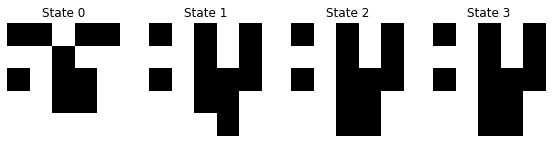

In [94]:
n_neurons = 25 
max_patterns = 4
    
stable_patterns = generate_stable_patterns(n_neurons, max_patterns, learning_rule='hebbian', mode='synchronous')
network = HopfieldNetwork(n_neurons, shape=(5,5))
network.train(stable_patterns, learning_rule='hebbian')
    
test_pattern = stable_patterns[0].copy()
test_pattern[:5] *= -1
    
print("Testowy wzorzec (zakłócony):")
print(test_pattern.reshape(5,5))
print()
states, energies = network.retrieve(test_pattern, mode='asynchronous')
print("Odzyskany wzorzec:")
print(states[-1].reshape(5,5))
print()
    
print("Wizualizacja wszystkich stanów jako bitmapy:")
network.plot_states_as_bitmaps(states)

### Tworzenie stanów oscylacyjnych
W poniższych komórkach próbujemy utworzyć stany, pomiędzy którymi nasza sieć będzie dokonwyała oscylacji.

In [125]:
def generate_custom_patterns():

    patterns = []

    A = np.array([
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1
    ])
    patterns.append(A)

    B = -A
    patterns.append(B)

    C = np.array([
        1, 1, 1, 1, 1,
        -1, -1, -1, -1, -1,
        1, 1, 1, 1, 1,
        -1, -1, -1, -1, -1,
        1, 1, 1, 1, 1
    ])
    patterns.append(C)

    D = -C
    patterns.append(D)

    E = np.array([
        1, -1, 1, -1, 1,
        1, -1, 1, -1, 1,
        1, -1, 1, -1, 1,
        1, -1, 1, -1, 1,
        1, -1, 1, -1, 1
    ])
    patterns.append(E)

    F = -E
    patterns.append(F)

    G = np.array([
        1, -1, -1, -1, -1,
        -1, 1, -1, -1, -1,
        -1, -1, 1, -1, -1,
        -1, -1, -1, 1, -1,
        -1, -1, -1, -1, 1
    ])
    patterns.append(G)

    H = -G
    patterns.append(H)

    return patterns

def create_oscillating_input_pattern():

    input_pattern = np.array([
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1
    ])
    input_pattern[12] = -input_pattern[12]  

    return input_pattern

Initialized HopfieldNetwork with 25 neurons and shape (5, 5)
Training with 8 patterns using hebbian rule.
Weights shape after training: (25, 25)
Wzorzec wejściowy (inicjujący oscylację):
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Starting retrieval with mode 'synchronous' and max_iterations=10000
Initial energy: -496.0
Iteration 1: Energy = -656.0
Iteration 2: Energy = -656.0
Convergence achieved.
Trajektoria stanów sieci:
Stan 0:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1 -1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Stan 1:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Stan 2:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Nie wykryto oscylacji między dwoma stanami.


Wizualizacja wszystkich stanów jako bitmapy:


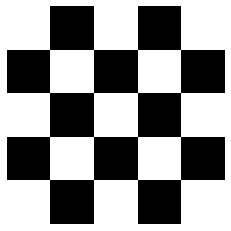

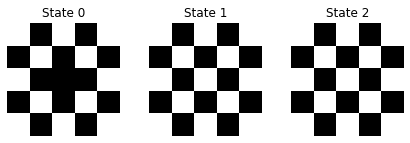

In [131]:
n_neurons = 25 
max_patterns = 4
network = HopfieldNetwork(n_neurons, shape=(5,5))

stable_patterns = generate_custom_patterns()

network.train(stable_patterns, learning_rule='hebbian')

oscillating_input = create_oscillating_input_pattern()

print("Wzorzec wejściowy (inicjujący oscylację):")
print(oscillating_input.reshape(5,5))
print()

states, energies = network.retrieve(oscillating_input, mode='synchronous', max_iterations=10000)

print("Trajektoria stanów sieci:")
for idx, state in enumerate(states):
    print(f"Stan {idx}:")
    print(state.reshape(5,5))
    print()

if len(states) >= 3:
    if np.array_equal(states[-1], states[-3]):
        print("Wykryto oscylację między dwoma stanami.")
    else:
            print("Nie wykryto oscylacji między dwoma stanami.")
else:
        print("Za mało stanów do sprawdzenia oscylacji.")

anim = network.interactive_visualize(states, interval=500, repeat=False)
display(HTML(anim.to_jshtml()))

print("Wizualizacja wszystkich stanów jako bitmapy:")
network.plot_states_as_bitmaps(states)

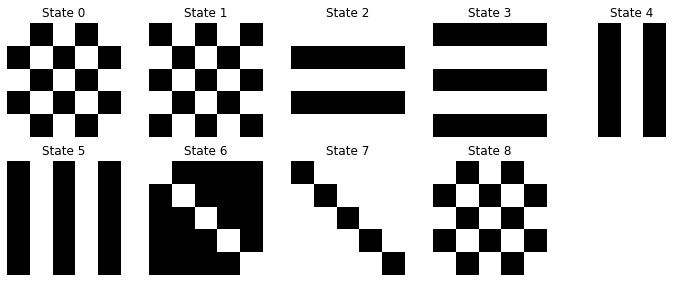

In [124]:
network.plot_states_as_bitmaps(generate_custom_patterns())

In [129]:
create_oscillating_input_pattern()

array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1])

## Zbiór różny, a zbiór podobny do siebie
Poniżej została przeprowadzony eksperyment sprawdzający jak wydajna będzie sieć dla zbiorów z dość podobnymi wzorcami, oraz dla zbiou z wzorcami dość różnymi od siebie.

In [160]:
from itertools import combinations

def generate_similar_patterns(base_pattern, variations=7, noise_level=0.05):

    patterns = [base_pattern]
    n_pixels = base_pattern.size
    n_noisy = int(n_pixels * noise_level)
    
    for _ in range(variations):
        noisy_pattern = base_pattern.copy()
        noisy_indices = np.random.choice(n_pixels, size=n_noisy, replace=False)
        noisy_pattern[noisy_indices] *= -1  
        patterns.append(noisy_pattern)
    
    return patterns

def generate_diverse_patterns(n_patterns, n_neurons):
    patterns = []
    for _ in range(n_patterns):
        pattern = np.random.choice([-1, 1], size=n_neurons)
        patterns.append(pattern)
    return patterns

def average_pixel_difference(patterns):
    pair_diffs = []
    for p1, p2 in combinations(patterns, 2):
        diff = np.sum(p1 != p2)
        pair_diffs.append(diff)
    avg_diff = np.mean(pair_diffs)
    return avg_diff

def plot_patterns(patterns, titles=None, shape=(25, 25), cols=4):
    n_patterns = len(patterns)
    rows = (n_patterns + cols - 1) // cols 
    
    plt.figure(figsize=(cols * 3, rows * 3))
    for idx, pattern in enumerate(patterns):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(pattern.reshape(shape), cmap='gray', vmin=-1, vmax=1)
        if titles:
            plt.title(titles[idx])
        else:
            plt.title(f'Pattern {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Generowanie Zbioru A: Podobne Wzorce
Wzorce Zbioru A:
Wzorzec A1:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Wzorzec A2:
[[-1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1  1  1 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1  1 -1  1]]

Wzorzec A3:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [-1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Wzorzec A4:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1 -1]]

Wzorzec A5:
[[ 1 -1  1 -1  1]
 [-1  1 -1  1  1]
 [ 1  1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1  1  1]]

Wzorzec A6:
[[ 1 -1  1  1  1]
 [-1  1 -1  1 -1]
 [ 1  1  1 -1  1]
 [-1  1  1  1 -1]
 [ 1 -1  1 -1  1]]

Wzorzec A7:
[[ 1 -1  1  1  1]
 [-1  1 -1 -1 -1]
 [ 1 -1  1 -1  1]
 [-1  1 -1  1 -1]
 [ 1  1  1 -1  1]]

Wzorzec A8:
[[ 1 -1 -1  1  1]
 [ 1  1 -1 -1 -1]
 [-1 -1 -1 -1  1]
 [-1  1 -1  1 -1]
 [ 1 -1  1 -1  1]]

Średnia różnica pixelowa w Zbiorze A: 4.36

Generowanie Zbioru B: Różnorodne Wzorce
Wzorce Zbioru B:
Wzorzec B1:
[

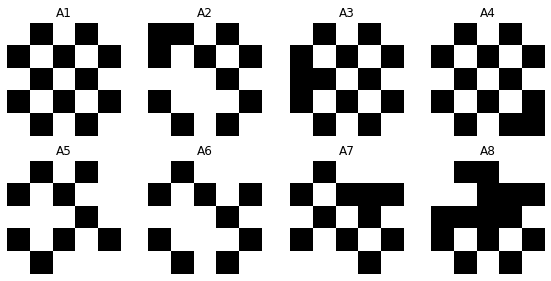

Wizualizacja Zbioru B: Różnorodne Wzorce
Initialized HopfieldNetwork with 25 neurons and shape (5, 5)


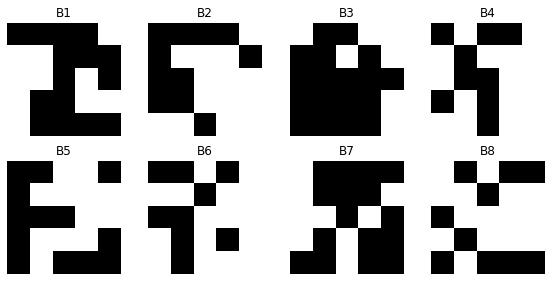


Podsumowanie:
Średnia różnica pixelowa w Zbiorze A (Podobne wzorce): 4.36
Średnia różnica pixelowa w Zbiorze B (Różnorodne wzorce): 12.46

Wnioski:
Zbiór A jest bardziej podobny wewnętrznie niż Zbiór B.


In [141]:
n_neurons = 25 
n_patterns = 8

print("Generowanie Zbioru A: Podobne Wzorce")
base_pattern_A = np.array([
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1,
        -1, 1, -1, 1, -1,
        1, -1, 1, -1, 1
    ])
similar_patterns = generate_similar_patterns(base_pattern_A, variations=7, noise_level=0.15)

print("Wzorce Zbioru A:")
for idx, pattern in enumerate(similar_patterns):
    print(f"Wzorzec A{idx+1}:")
    print(pattern.reshape(5,5))
    print()

avg_diff_A = average_pixel_difference(similar_patterns)
print(f"Średnia różnica pixelowa w Zbiorze A: {avg_diff_A:.2f}")

print("\nGenerowanie Zbioru B: Różnorodne Wzorce")
diverse_patterns = generate_diverse_patterns(n_patterns=8, n_neurons=n_neurons)

print("Wzorce Zbioru B:")
for idx, pattern in enumerate(diverse_patterns):
    print(f"Wzorzec B{idx+1}:")
    print(pattern.reshape(5,5))
    print()

avg_diff_B = average_pixel_difference(diverse_patterns)
print(f"Średnia różnica pixelowa w Zbiorze B: {avg_diff_B:.2f}")

print("\nWizualizacja Zbioru A: Podobne Wzorce")
network_A = HopfieldNetwork(n_neurons, shape=(5,5))
network_A.plot_states_as_bitmaps(similar_patterns, titles=[f'A{idx+1}' for idx in range(n_patterns)])

print("Wizualizacja Zbioru B: Różnorodne Wzorce")
network_B = HopfieldNetwork(n_neurons, shape=(5,5))
network_B.plot_states_as_bitmaps(diverse_patterns, titles=[f'B{idx+1}' for idx in range(n_patterns)])

print("\nPodsumowanie:")
print(f"Średnia różnica pixelowa w Zbiorze A (Podobne wzorce): {avg_diff_A:.2f}")
print(f"Średnia różnica pixelowa w Zbiorze B (Różnorodne wzorce): {avg_diff_B:.2f}")

print("\nWnioski:")
if avg_diff_A < avg_diff_B:
    print("Zbiór A jest bardziej podobny wewnętrznie niż Zbiór B.")
else:
    print("Zbiór B jest bardziej zróżnicowany niż Zbiór A.")

Generowanie Zbioru A: Podobne Wzorce
Wzorce Zbioru A:
Wzorzec A1:
[[ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  -1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  -1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  -1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  -1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  -1]
 [ 1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1
   1]
 [-1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  

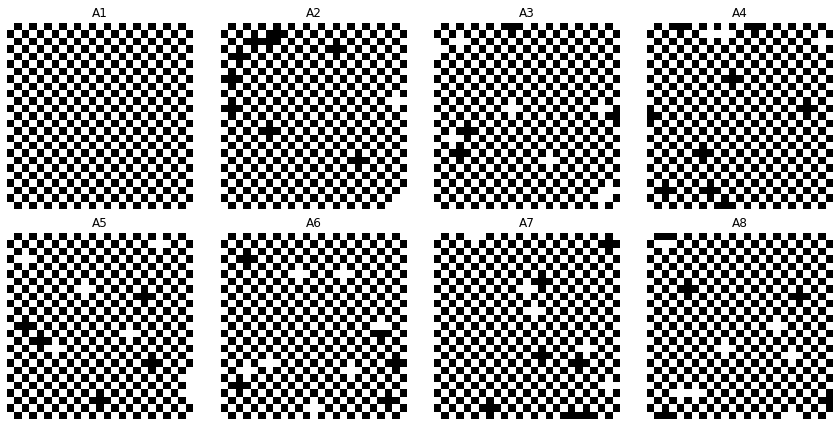

Wizualizacja Zbioru B: Różnorodne Wzorce


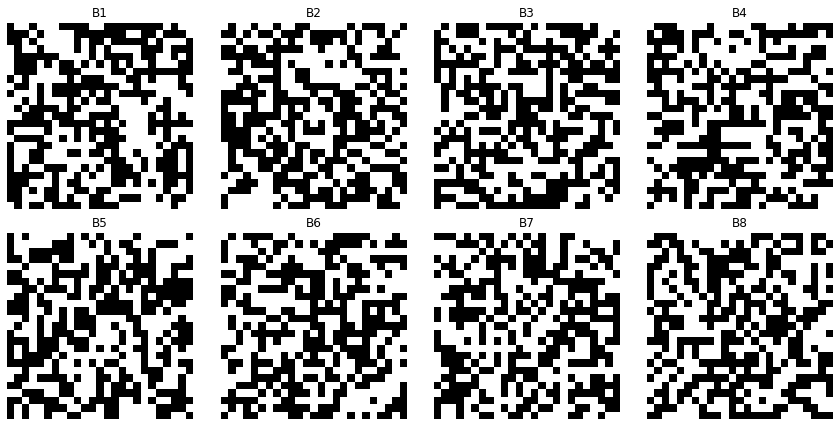


Podsumowanie:
Średnia różnica pixelowa w Zbiorze A (Podobne wzorce): 20.86
Średnia różnica pixelowa w Zbiorze B (Różnorodne wzorce): 313.25

Wnioski:
Zbiór A jest bardziej podobny wewnętrznie niż Zbiór B.


In [161]:
n_neurons = 625
n_patterns = 8  
    
print("Generowanie Zbioru A: Podobne Wzorce")
base_pattern_A = np.array([1 if (i+j) % 2 == 0 else -1 for i in range(25) for j in range(25)])
similar_patterns = generate_similar_patterns(base_pattern_A, variations=7, noise_level=0.02) 
    
print("Wzorce Zbioru A:")
for idx, pattern in enumerate(similar_patterns):
    print(f"Wzorzec A{idx+1}:")
    print(pattern.reshape(25,25))
    print()
    
avg_diff_A = average_pixel_difference(similar_patterns)
print(f"Średnia różnica pixelowa w Zbiorze A: {avg_diff_A:.2f}")
    
print("\nGenerowanie Zbioru B: Różnorodne Wzorce")
diverse_patterns = generate_diverse_patterns(n_patterns=8, n_neurons=n_neurons)
    
print("Wzorce Zbioru B:")
for idx, pattern in enumerate(diverse_patterns):
    print(f"Wzorzec B{idx+1}:")
    print(pattern.reshape(25,25))
    print()
    
avg_diff_B = average_pixel_difference(diverse_patterns)
print(f"Średnia różnica pixelowa w Zbiorze B: {avg_diff_B:.2f}")
    
print("\nWizualizacja Zbioru A: Podobne Wzorce")
plot_titles_A = [f'A{idx+1}' for idx in range(n_patterns)]
plot_patterns(similar_patterns, titles=plot_titles_A, shape=(25,25), cols=4)
    
print("Wizualizacja Zbioru B: Różnorodne Wzorce")
plot_titles_B = [f'B{idx+1}' for idx in range(n_patterns)]
plot_patterns(diverse_patterns, titles=plot_titles_B, shape=(25,25), cols=4)
    
print("\nPodsumowanie:")
print(f"Średnia różnica pixelowa w Zbiorze A (Podobne wzorce): {avg_diff_A:.2f}")
print(f"Średnia różnica pixelowa w Zbiorze B (Różnorodne wzorce): {avg_diff_B:.2f}")
    
print("\nWnioski:")
if avg_diff_A < avg_diff_B:
    print("Zbiór A jest bardziej podobny wewnętrznie niż Zbiór B.")
else:
    print("Zbiór B jest bardziej zróżnicowany niż Zbiór A.")

In [165]:
import random
def flip_bits(pattern, percentage):
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")
    pattern = np.array(pattern)
    
    n_bits = pattern.size
    n_flip = int(np.round((percentage / 100.0) * n_bits))
    if n_flip == 0:
        return pattern.copy()
    
    flip_indices = np.random.choice(n_bits, size=n_flip, replace=False)
    flipped_pattern = pattern.copy()
    
    flipped_pattern[flip_indices] *= -1
    
    return flipped_pattern

In [177]:
random.seed(1337)
pattern_count = np.zeros(len(similar_patterns)+1)


for _ in range(1000):
    network = HopfieldNetwork(n_neurons=625, shape=(25, 25))

    network.train(similar_patterns, learning_rule='hebbian')

    noisy_pattern = random.randint(0, len(similar_patterns)-1)
    noisy_pattern = flip_bits(similar_patterns[noisy_pattern], 0.8)
    
    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(similar_patterns):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)
print(f"Accuracy is equal to {np.sum(pattern_count[:len(pattern_count)-1])/np.sum(pattern_count)}")

Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -1325720.0
Iteration 1: Energy = -1457016.0
Iteration 2: Energy = -1457016.0
Convergence achieved.
Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -1330272.0
Iteration 1: Energy = -1457016.0
Iteration 2: Energy = -1457016.0
Convergence achieved.
Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -1325720.0
Iteration 1: Energy = -1457016.0
Iteration 2: Energy = -1457016.0
Convergence achieved.
Init

In [180]:
random.seed(1337)
pattern_count = np.zeros(len(diverse_patterns)+1)


for _ in range(1000):
    network = HopfieldNetwork(n_neurons=625, shape=(25, 25))

    network.train(diverse_patterns, learning_rule='hebbian')

    noisy_pattern = random.randint(0, len(diverse_patterns)-1)
    noisy_pattern = flip_bits(diverse_patterns[noisy_pattern], 0.4)
    
    states = network.retrieve(noisy_pattern, mode='asynchronous')
    
    matched = False
    for idx, pattern in enumerate(diverse_patterns):
        if np.array_equal(network.state, pattern) or np.array_equal(-1 * network.state, pattern):
                pattern_count[idx] += 1
                matched = True
                break  
    if not matched:
        pattern_count[-1] += 1

print(pattern_count)
print(f"Accuracy is equal to {np.sum(pattern_count[:len(pattern_count)-1])/np.sum(pattern_count)}")

Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -191896.0
Iteration 1: Energy = -194112.0
Iteration 2: Energy = -194112.0
Convergence achieved.
Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -193344.0
Iteration 1: Energy = -195892.0
Iteration 2: Energy = -195892.0
Convergence achieved.
Initialized HopfieldNetwork with 625 neurons and shape (25, 25)
Training with 8 patterns using hebbian rule.
Weights shape after training: (625, 625)
Starting retrieval with mode 'asynchronous' and max_iterations=100
Initial energy: -191824.0
Iteration 1: Energy = -194112.0
Iteration 2: Energy = -194112.0
Convergence achieved.
Initialized H

In [159]:
similar_patterns[:2]

[array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1]),
 array([-1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,
         1,  1, -1,  1, -1,  1, -1,  1])]

## Eksperyment, duże bitmapy
Poniżej dokonujemy przeprowadzenia eksperymentu na dużych bitmatpach (będą to zdjęcia kotów). W tym eksperymencie nie będziemy dokonywać większych oględzin względem ewaluacji danego zbioru (gdyż jest to dość trudne, a czasem wręcz niemożliwe). Toteż dokonamy uczenia sieci na zbiorze ze zdjęciami kotów, a następnie przyjżymy się kilku przypadkom rozpoznawania przez sieć danych wzorców poprzez wpuszczenie doń zniekształconych bitmap przedstawiających koty ze zbioru treningowego.

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations
import random
import os

def flip_bits(pattern, percentage):

    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")
    pattern = np.array(pattern)
    
    n_bits = pattern.size
    n_flip = int(np.round((percentage / 100.0) * n_bits))
    if n_flip == 0:
        return pattern.copy()
    
    flip_indices = np.random.choice(n_bits, size=n_flip, replace=False)
    
    flipped_pattern = pattern.copy()
    flipped_pattern[flip_indices] *= -1
    
    return flipped_pattern


def load_and_preprocess_images(directory, num_images=30, size=(200, 300)):

    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    patterns = []
    for file in selected_files:
        path = os.path.join(directory, file)
        with Image.open(path) as img:
            img = img.convert('L')  
            img = img.resize(size)  
            img_array = np.array(img)
           
            binary_array = np.where(img_array >= 128, 1, -1)
            patterns.append(binary_array.flatten())
    return patterns, selected_files

def average_pixel_difference(patterns):
    pair_diffs = []
    for p1, p2 in combinations(patterns, 2):
        diff = np.sum(p1 != p2)
        pair_diffs.append(diff)
    avg_diff = np.mean(pair_diffs)
    return avg_diff

def plot_patterns(patterns, titles=None, shape=(200,300), cols=4):

    n_patterns = len(patterns)
    rows = (n_patterns + cols - 1) // cols 
    
    plt.figure(figsize=(cols * 5, rows * 5))
    for idx, pattern in enumerate(patterns):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(pattern.reshape(shape), cmap='gray', vmin=-1, vmax=1)
        if titles:
            plt.title(titles[idx])
        else:
            plt.title(f'Pattern {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def introduce_noise(pattern, noise_level=30):
    return flip_bits(pattern, noise_level)

Ładowanie i preprocessing obrazów...
Załadowano 30 obrazów.
Średnia różnica pixelowa w zbiorze uczącym: 29190.67

Wizualizacja Zbioru Uczącego:


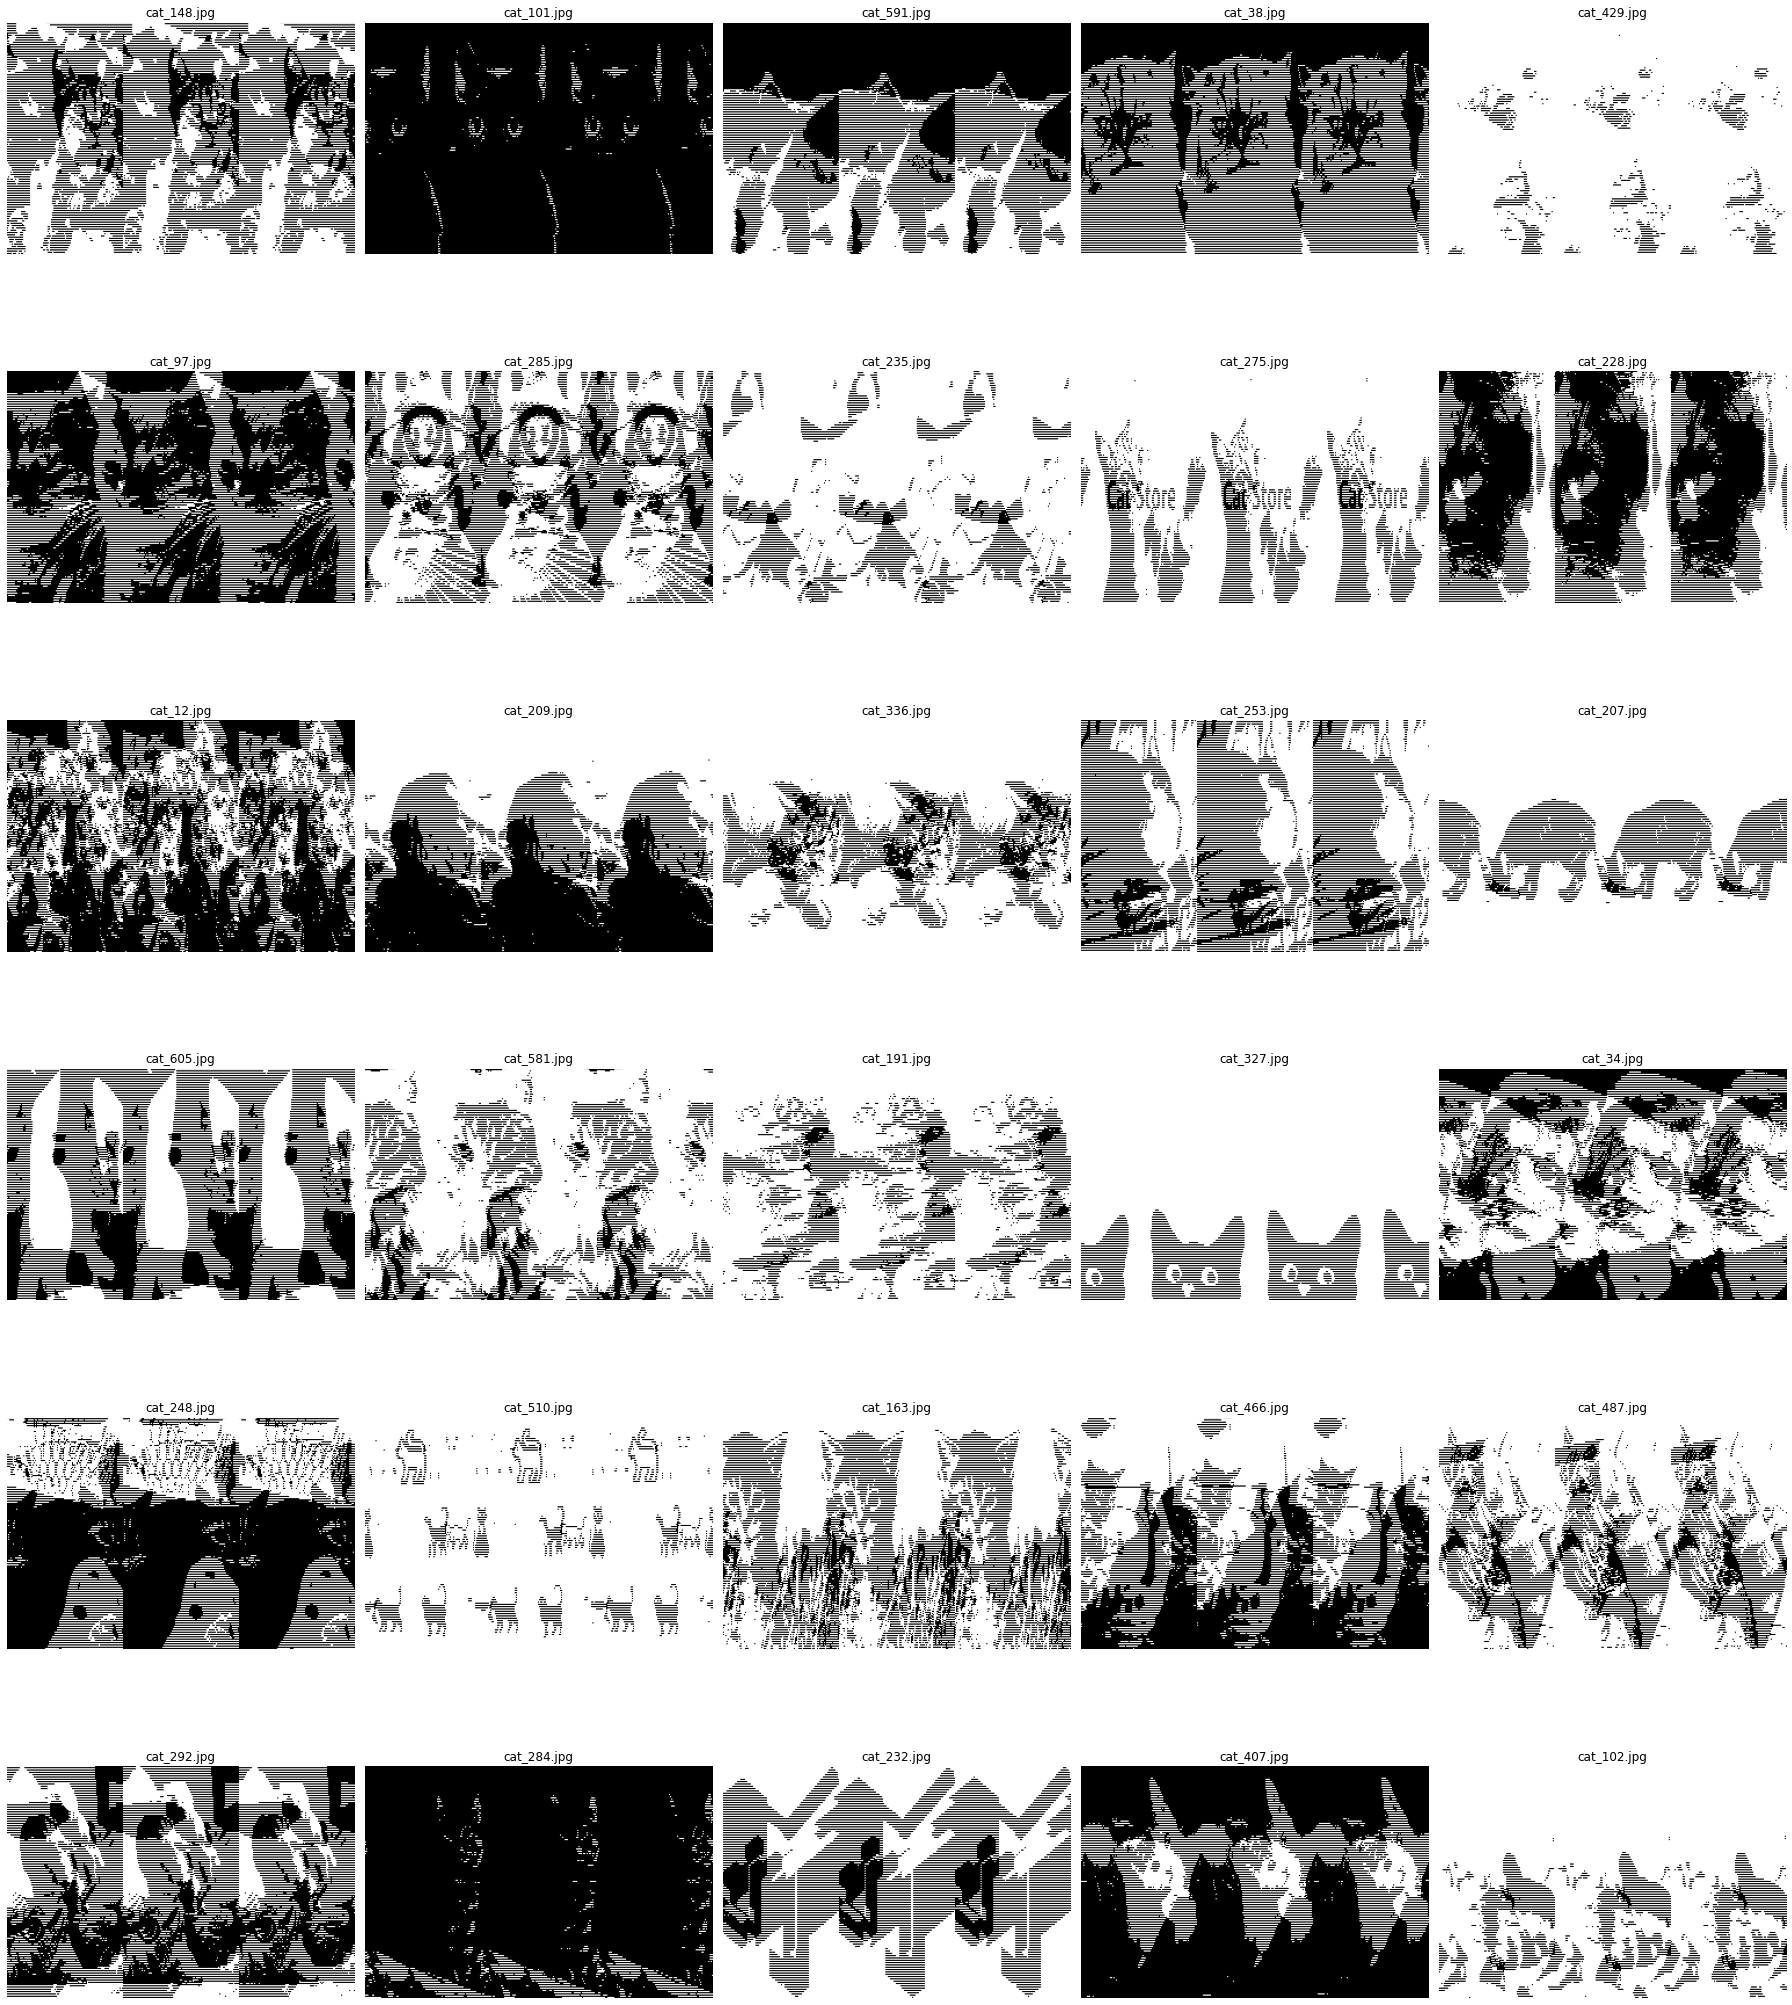


Trenowanie sieci Hopfielda...
Initialized HopfieldNetwork with 60000 neurons and shape (200, 300)
Training with 30 patterns using hebbian rule.


KeyboardInterrupt: 

In [190]:
directory = r"D:\Pulpit\SN_MINI\Hopfield_Network_Project\Data\CatsDogsData\ImageUnprocessed\train\cats"

num_images = 30
image_size = (200, 300) 
num_distorted = 10
noise_percentage = 30 

print("Ładowanie i preprocessing obrazów...")
patterns, filenames = load_and_preprocess_images(directory, num_images=num_images, size=image_size)
print(f"Załadowano {len(patterns)} obrazów.")

avg_diff = average_pixel_difference(patterns)
print(f"Średnia różnica pixelowa w zbiorze uczącym: {avg_diff:.2f}")

print("\nWizualizacja Zbioru Uczącego:")
plot_patterns(patterns, titles=filenames, shape=image_size, cols=5)

print("\nTrenowanie sieci Hopfielda...")
n_neurons = patterns[0].size
hopfield_net = HopfieldNetwork(n_neurons, shape=image_size)
hopfield_net.train(patterns, learning_rule='hebbian')

print("\nWybór podzbioru do testowania...")
test_indices = random.sample(range(num_images), num_distorted)
test_patterns = [patterns[i] for i in test_indices]
test_filenames = [filenames[i] for i in test_indices]

print("\nWprowadzanie zakłóceń do wybranych wzorców...")
distorted_patterns = [introduce_noise(p, noise_level=noise_percentage) for p in test_patterns]

print("\nOdzyskiwanie wzorców przez sieć Hopfielda...")
recovered_patterns = []
for idx, distorted in enumerate(distorted_patterns):
    print(f"\nTestowanie wzorca {idx+1}: {test_filenames[idx]}")
    states, energies = hopfield_net.retrieve(distorted, mode='asynchronous', max_iterations=10)
    recovered = states[-1]
    recovered_patterns.append(recovered)

print("\nWizualizacja wyników:")
for idx in range(num_distorted):
    original = test_patterns[idx].reshape(image_size)
    distorted = distorted_patterns[idx].reshape(image_size)
    recovered = recovered_patterns[idx].reshape(image_size)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.imshow(original, cmap='gray', vmin=-1, vmax=1)
    plt.title(f'Oryginał: {test_filenames[idx]}')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(distorted, cmap='gray', vmin=-1, vmax=1)
    plt.title(f'Zakłócony ({noise_percentage}%): {test_filenames[idx]}')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(recovered, cmap='gray', vmin=-1, vmax=1)
    plt.title(f'Odzyskany: {test_filenames[idx]}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nAnaliza wyników:")
for idx in range(num_distorted):
    original = test_patterns[idx]
    recovered = recovered_patterns[idx]
    correct_pixels = np.sum(original == recovered)
    total_pixels = original.size
    accuracy = (correct_pixels / total_pixels) * 100
    print(f"Wzorzec {idx+1}: {test_filenames[idx]}")
    print(f"Dokładność: {accuracy:.2f}% ({correct_pixels}/{total_pixels} pikseli poprawnych)\n")